In [1]:
import cv2
import os
from PIL import Image
import numpy as np
#import Augmentor
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2024-05-05 11:16:34.044963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 11:16:34.045088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 11:16:34.184170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
paths = ['/kaggle/input/birad-mamo3/BIRAD-mamo3/BIRAD-mamo', '/kaggle/input/ultrasound/data', '/kaggle/input/thermo/thermo1']

data_dict = {} 

for i, path in enumerate(paths):
    base_path = os.path.join(path)
    dir_path = os.listdir(base_path)
    if path == '/kaggle/input/birad-mamo3/BIRAD-mamo3/BIRAD-mamo':
        dir_path.reverse()
    elif path == '/kaggle/input/ultrasound/data':
        dir_path = sorted(dir_path, key=lambda x: ['normal', 'benign', 'malignant'].index(x.lower()))
    print(dir_path)

    files = []
    labels = []
    
    def img_preprocessing(img_path):
        img = load_img(img_path, target_size=(224, 224)) 
        img = img_to_array(img)  # Convert to NumPy array
        #img = np.expand_dims(img, axis=0)# Add a batch dimension (needed for the model)
        img = preprocess_input(img)  
        return img
    
    for i, img_class in enumerate(dir_path):
        for image in os.listdir(os.path.join(base_path,img_class)):
            img_path = os.path.join(base_path,img_class,image)
            img_array = img_preprocessing(img_path)
            files.append(img_array)
            labels.append(i)
    indices = np.arange(len(files))
    np.random.shuffle(indices)
    m_files = []
    m_labels = []
    for indice in indices:
        m_files.append(files[indice])
        m_labels.append(labels[indice])
    
    x_train, x_test, y_train, y_test = train_test_split(m_files, m_labels, test_size = 0.2, random_state=42)
    
    data_dict[path] = {
        f'x_train_{path[-1]}': np.array(x_train),
        f'y_train_{path[-1]}': np.array(y_train),
        f'x_test_{path[-1]}': np.array(x_test),
        f'y_test_{path[-1]}': np.array(y_test)
    }
    count_train = [np.sum(np.array(y_train) == i) for i in range(len(dir_path))]
    count_test = [np.sum(np.array(y_test) == i) for i in range(len(dir_path))]

    print("Train Counts:", count_train)
    print("Test Counts:", count_test)
    

['normalB1', 'benignB3', 'malignantB45']
Train Counts: [1020, 958, 889]
Test Counts: [253, 229, 235]
['normal', 'benign', 'malignant']
Train Counts: [351, 349, 348]
Test Counts: [86, 88, 89]
['Benign', 'malignant']
Train Counts: [619, 598]
Test Counts: [143, 162]


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,Activation
from tensorflow.keras.initializers import GlorotUniform, HeNormal
import matplotlib.pyplot as plt
from keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.models import save_model
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model

In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

# Define input shapes
input_shape_mammography = (224, 224, 3)  
input_shape_ultrasound = (224, 224, 3)  
input_shape_thermal = (224, 224, 3)

# Load weights only once
base = InceptionResNetV2(weights=None, include_top=False)
base.load_weights("/kaggle/input/radimagenet-irv2/RadImageNet-IRV2_notop.h5")

# Define input layers for each modality
input_mammography = Input(shape=input_shape_mammography)
input_ultrasound = Input(shape=input_shape_ultrasound)
input_thermal = Input(shape=input_shape_thermal)

# Extract features from each modality using the shared base model
features_mammography = base(input_mammography)
features_ultrasound = base(input_ultrasound)
features_thermal = base(input_thermal)

# Flatten features from each modality
flatten_mammography1 = Flatten()(features_mammography)
flatten_ultrasound1 = Flatten()(features_ultrasound)
flatten_thermal1 = Flatten()(features_thermal)

flatten_mammography2 = GlobalAveragePooling2D()(features_mammography)
flatten_ultrasound2 = GlobalAveragePooling2D()(features_ultrasound)
flatten_thermal2 = GlobalAveragePooling2D()(features_thermal)

# Concatenate flattened features
x = Concatenate(axis=-1)([flatten_mammography1, flatten_ultrasound1, flatten_thermal1,flatten_mammography2, flatten_ultrasound2, flatten_thermal2])

# Classification layers
#x = BatchNormalization()(concatenated_features)
#x = Dropout(0.3)(x)
x = Dense(48, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.4))(x)
#x = BatchNormalization()(x)

output_mammography = Dense(3, activation='softmax', name='mammography_output')(x)  
output_ultrasound = Dense(3, activation='softmax', name='ultrasound_output')(x)  
output_thermal = Dense(2, activation='softmax', name='thermal_output')(x) 

# Define the multimodal model with multiple outputs
model = Model(inputs=[input_mammography, input_ultrasound, input_thermal ], outputs=[output_mammography, output_ultrasound, output_thermal])


model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss={'mammography_output': SparseCategoricalCrossentropy(),
                    'ultrasound_output': SparseCategoricalCrossentropy(),
                    'thermal_output': SparseCategoricalCrossentropy()},
              metrics={'mammography_output': 'accuracy', 
                       'ultrasound_output': 'accuracy', 
                       'thermal_output': 'accuracy'})

In [49]:
for layer in model.layers:
    print(layer)

<InputLayer name=input_layer_63, built=True>
<InputLayer name=input_layer_64, built=True>
<InputLayer name=input_layer_65, built=True>
<Functional name=inception_resnet_v2, built=True>
<Functional name=resnet50, built=True>
<Functional name=inception_v3, built=True>
<Flatten name=flatten_33, built=True>
<Flatten name=flatten_34, built=True>
<Flatten name=flatten_35, built=True>
<GlobalAveragePooling2D name=global_average_pooling2d_15, built=True>
<GlobalAveragePooling2D name=global_average_pooling2d_16, built=True>
<GlobalAveragePooling2D name=global_average_pooling2d_17, built=True>
<Concatenate name=concatenate_32, built=True>
<Dense name=mammography_output, built=True>
<Dense name=ultrasound_output, built=True>
<Dense name=thermal_output, built=True>


In [19]:
for layer in model.layers:
    if layer.name in ['inception_resnet_v2']:
        base_model = layer
        for base_layer in base_model.layers:
            if base_layer.name in ['conv_7b']:
                base_layer.trainable = True
            else:
                base_layer.trainable = False
            
    elif layer.name in ['dense_3', 'mammography_output', 'ultrasound_output', 'thermal_output']:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_resnet_v2 │ (None, 5, 5,      │ 54,336,736 │ input_layer_9[0]… │
│ (Functional)        │ 1536)             │            │ input_layer_10[0… │
│                     │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 38400)     │          0 │ inception_resnet… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 38400)     │          0 │ inception_resnet… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 38400)     │          0 │ inception_resnet… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ inception_resnet… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ inception_resnet… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ inception_resnet… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 119808)    │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ flatten_8[0][0],  │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 48)        │  5,750,832 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mammography_output  │ (None, 3)         │        147 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ultrasound_output   │ (None, 3)         │        147 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ thermal_output      │ (None, 2)         │         98 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,087,960 (229.22 MB)

 Trainable params: 8,946,104 (34.13 MB)

 Non-trainable params: 51,141,856 (195.09 MB)

In [20]:
history = model.fit([x_train_0_subset, x_train_1_subset, x_train_2_subset], 
          [y_train_0_subset, y_train_1_subset, y_train_2_subset], 
          batch_size=64, epochs=20, validation_split=0.25)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - loss: 38.1726 - mammography_output_accuracy: 0.3721 - thermal_output_accuracy: 0.5570 - ultrasound_output_accuracy: 0.3701 - val_loss: 27.6641 - val_mammography_output_accuracy: 0.4809 - val_thermal_output_accuracy: 0.5267 - val_ultrasound_output_accuracy: 0.4160
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 610ms/step - loss: 24.9386 - mammography_output_accuracy: 0.5114 - thermal_output_accuracy: 0.6851 - ultrasound_output_accuracy: 0.4441 - val_loss: 17.9563 - val_mammography_output_accuracy: 0.4962 - val_thermal_output_accuracy: 0.5802 - val_ultrasound_output_accuracy: 0.5611
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 607ms/step - loss: 16.1437 - mammography_output_accuracy: 0.5837 - thermal_output_accuracy: 0.6711 - ultrasound_output_accuracy: 0.5978 - val_loss: 11.9601 - val_mammography_output_accuracy: 0.5229 - val_thermal_output_accuracy: 0.7786 - val_ultrasound_output_accuracy: 0.5458
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 609ms/

In [16]:
# Determine the minimum number of samples among all modalities
min_samples = min(len(x_train_0), len(x_train_1), len(x_train_2))

# Randomly select subset of samples to match the minimum number
indices_0 = np.random.choice(len(x_train_0), min_samples, replace=False)
indices_1 = np.random.choice(len(x_train_1), min_samples, replace=False)
indices_2 = np.random.choice(len(x_train_2), min_samples, replace=False)

# Select subset of data based on the randomly chosen indices
x_train_0_subset = x_train_0[indices_0]
x_train_1_subset = x_train_1[indices_1]
x_train_2_subset = x_train_2[indices_2]

y_train_0_subset = y_train_0[indices_0]
y_train_1_subset = y_train_1[indices_1]
y_train_2_subset = y_train_2[indices_2]
#y_train_2_subset = np.reshape(y_train_2_subset, (-1, 1))

In [12]:
len(x_train_0_subset),len(x_train_1_subset),len(x_train_2_subset)

(1048, 1048, 1048)

In [15]:
for path, data in data_dict.items():
    print(f"Path: {path}")
    print("Keys:", data.keys())

Path: /kaggle/input/birad-mamo3/BIRAD-mamo3/BIRAD-mamo
Keys: dict_keys(['x_train_o', 'y_train_o', 'x_test_o', 'y_test_o'])
Path: /kaggle/input/ultrasound/data
Keys: dict_keys(['x_train_a', 'y_train_a', 'x_test_a', 'y_test_a'])
Path: /kaggle/input/thermo/thermo1
Keys: dict_keys(['x_train_1', 'y_train_1', 'x_test_1', 'y_test_1'])


In [14]:
# Retrieve and assign variables from the data_dict

x_train_0 = data_dict[paths[0]]['x_train_o']
y_train_0 = data_dict[paths[0]]['y_train_o']
x_test_0 = data_dict[paths[0]]['x_test_o']
y_test_0 = data_dict[paths[0]]['y_test_o']

x_train_1 = data_dict[paths[1]]['x_train_a']
y_train_1 = data_dict[paths[1]]['y_train_a']
x_test_1 = data_dict[paths[1]]['x_test_a']
y_test_1 = data_dict[paths[1]]['y_test_a']

x_train_2 = data_dict[paths[2]]['x_train_1']
y_train_2 = data_dict[paths[2]]['y_train_1']
x_test_2 = data_dict[paths[2]]['x_test_1']
y_test_2 = data_dict[paths[2]]['y_test_1']

In [21]:
min_samples = min(len(x_test_0), len(x_test_1), len(x_test_2))
indices_0 = np.random.choice(len(x_test_0), min_samples, replace=False)
indices_1 = np.random.choice(len(x_test_1), min_samples, replace=False)
indices_2 = np.random.choice(len(x_test_2), min_samples, replace=False)

x_test_0_subset = x_test_0[indices_0]
x_test_1_subset = x_test_1[indices_1]
x_test_2_subset = x_test_2[indices_2]

y_test_0_subset = y_test_0[indices_0]
y_test_1_subset = y_test_1[indices_1]
y_test_2_subset = y_test_2[indices_2]

In [22]:
loss, accuracy_mammography, accuracy_ultrasound, accuracy_thermal = model.evaluate([x_test_0_subset, x_test_1_subset, x_test_2_subset], 
                                                                                   [y_test_0_subset, y_test_1_subset, y_test_2_subset])
print("Test Loss:", loss)
print("Test Accuracy (Mammography):", accuracy_mammography)
print("Test Accuracy (Ultrasound):", accuracy_ultrasound)
print("Test Accuracy (Thermal):", accuracy_thermal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 2.3379 - mammography_output_accuracy: 0.5800 - thermal_output_accuracy: 0.9557 - ultrasound_output_accuracy: 0.7046 
Test Loss: 2.3783106803894043
Test Accuracy (Mammography): 0.5931559205055237
Test Accuracy (Ultrasound): 0.9429658055305481
Test Accuracy (Thermal): 0.6958174705505371


In [16]:
print(history.history.keys())

dict_keys(['loss', 'mammography_output_accuracy', 'thermal_output_accuracy', 'ultrasound_output_accuracy', 'val_loss', 'val_mammography_output_accuracy', 'val_thermal_output_accuracy', 'val_ultrasound_output_accuracy'])


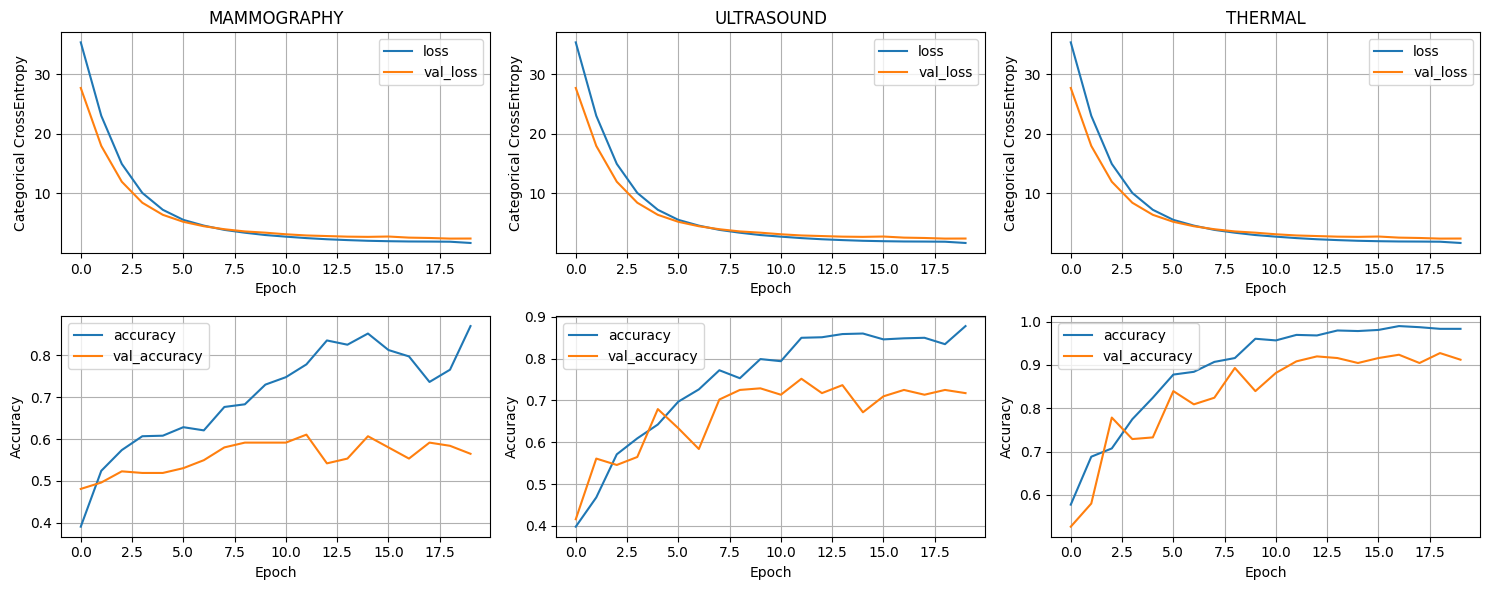

In [23]:
import matplotlib.pyplot as plt

def plot_history(history, modalities):
    fig, axes = plt.subplots(2, len(modalities), figsize=(15, 6))
    
    for i, modality in enumerate(modalities):
        ax1, ax2 = axes[:, i]
        
        ax1.plot(history.history['loss'], label='loss')
        ax1.plot(history.history[f'val_loss'], label='val_loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Categorical CrossEntropy')
        ax1.legend() 
        ax1.grid(True)
        ax1.set_title(modality.upper())
        
        ax2.plot(history.history[f'{modality}_output_accuracy'], label='accuracy')
        ax2.plot(history.history[f'val_{modality}_output_accuracy'], label='val_accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

modalities = ['mammography', 'ultrasound', 'thermal']
plot_history(history, modalities)